In [1]:
# Lib Imports
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
import category_encoders as ce

In [2]:
# Setting Pandas column display option
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
%%time
idee = pd.read_csv('train_identity.csv')
transaction = pd.read_csv('train_transaction.csv')

Wall time: 15.9 s


In [4]:
%%time
def pipeline(idee, transaction):
    merge = transaction.merge(idee, how='outer', on='TransactionID')
    objects = merge.select_dtypes('object')
    objects = objects.join(merge[['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']])
    objects['isFraud'] = merge['isFraud']
    objects.fillna("Unknown", inplace=True)
    objects = objects.astype('category')
    print(objects.info())
    return objects
objects = pipeline(idee,transaction)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   ProductCD      590540 non-null  category
 1   card4          590540 non-null  category
 2   card6          590540 non-null  category
 3   P_emaildomain  590540 non-null  category
 4   R_emaildomain  590540 non-null  category
 5   M1             590540 non-null  category
 6   M2             590540 non-null  category
 7   M3             590540 non-null  category
 8   M4             590540 non-null  category
 9   M5             590540 non-null  category
 10  M6             590540 non-null  category
 11  M7             590540 non-null  category
 12  M8             590540 non-null  category
 13  M9             590540 non-null  category
 14  id_12          590540 non-null  category
 15  id_15          590540 non-null  category
 16  id_16          590540 non-null  category
 17  id_23     

In [5]:
# objects.drop(columns=['M4','id_15','id_16','id_28','id_29','id_35','id_36','id_38','DeviceType','DeviceInfo'], inplace=True)
objects.shape

(590540, 38)

In [6]:
%%time
X  = objects.drop(columns='isFraud')
y = objects['isFraud'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                                sampling_strategy='auto',
                                replacement=True,
                                random_state=0,
                                n_estimators=100)


Wall time: 120 ms


In [7]:
columns = X_train.columns.to_list()

def get_score(model, X, y, X_test, y_test):
    model.fit(X, y)
    y_pred = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, y_pred)
    return score

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(413378, 37) (177162, 37) (413378,) (177162,)


In [9]:
%%time
# n_components_list = np.arange(100, 4000, 100).tolist()
n_components_list = [500]
n_components_list_str = [str(i) for i in n_components_list]

fh_logit_scores = []

for n_components in n_components_list:
    hashing_enc = ce.HashingEncoder(cols=columns, n_components=n_components).fit(X_train, y_train)
    
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
    X_test_hashing = hashing_enc.transform(X_test.reset_index(drop=True))
    
    fe_logit_score = get_score(bbc, X_train_hashing, y_train, X_test_hashing, y_test)
    fh_logit_scores.append(fe_logit_score)

Wall time: 18min 43s


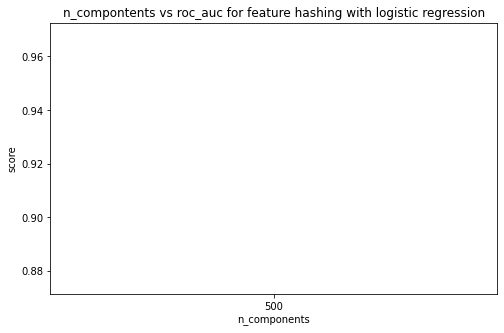

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(n_components_list_str, fh_logit_scores, linewidth=3)
plt.title('n_compontents vs roc_auc for feature hashing with logistic regression')
plt.xlabel('n_components')
plt.ylabel('score')
plt.show()

In [11]:
fh_logit_scores

[0.9218821239271188]

In [ ]:
growth_rate = np.exp(np.diff(np.log(fh_logit_scores))) - 1

In [ ]:
growth_rate

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(n_components_list_str, growth_rate, linewidth=3)
plt.title('n_compontents vs growth_rate for feature hashing with logistic regression')
plt.xlabel('n_components')
plt.ylabel('GRate')
plt.show()

## Test dataset benchmarking

In [ ]:
%%time
hashing_enc = ce.HashingEncoder(cols=columns, n_components=1700, max_process=4).fit(X_train, y_train)
X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
X_test_hashing = hashing_enc.transform(X_test.reset_index(drop=True))
print(X_train_hashing.shape, y_train.shape)

In [ ]:
%%time
idee_test = pd.read_csv('test_identity.csv')
transaction_test = pd.read_csv('test_transaction.csv') 
merge_test = transaction_test.merge(idee_test, how='outer', on='TransactionID')
objects_test = merge_test.select_dtypes('object')
objects_test.fillna("Unknown", inplace=True)
objects_test = objects_test.astype('category')
objects_test.columns = X_train.columns
print(objects_test.info())
del idee_test, transaction_test

In [ ]:
X2_hashed = hashing_enc.transform(objects_test.reset_index(drop=True), override_return_df=True)

In [ ]:
%%time
X2_hashed.head()

In [ ]:
%%time
logit.fit(X_train_hashing, y_train)
y_pred_train = logit.predict(X_test_hashing)
from sklearn.metrics import classification_report
print(classification_report(y_pred_train, y_test))

In [ ]:
%%time
y_pred = logit.predict(X2_hashed)

In [ ]:
y_pred